<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
from datetime import date
import math
from scipy.stats import pearsonr

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

In [2]:
try: 
    data = pd.read_csv('C:/Users/Денис/Desktop/python/teacher/Churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Описательная статистика столбца "CreditScore":
Среднее: 650.53±0.97
Медиана: 652.0, межквартильный размах: 134.0
Минимальное значение: 350.0. Максимальное значение: 850.0.


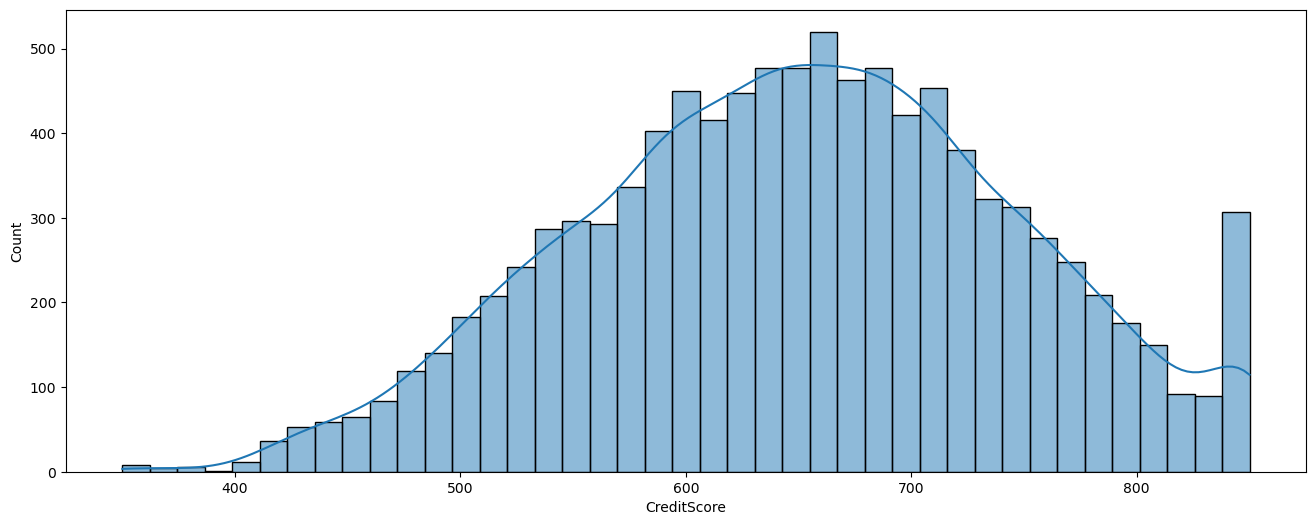

In [4]:
def description_and_plot (data, column):
    plt.figure(figsize=(16, 6))
    g = sns.histplot(data=data, x=data[column], kde=True)
    stat = data[column].describe()
    print(f'Описательная статистика столбца "{column}":\n'
          f'Среднее: {round(stat[1],2)}±{round(stat[2]/math.sqrt(stat[0]),2)}\n'
          f'Медиана: {round(stat[5],2)}, межквартильный размах: {round(stat[6]-stat[4],2)}\n'
          f'Минимальное значение: {round(stat[3],2)}. Максимальное значение: {round(stat[7],2)}.' );
    return 

description_and_plot(data=data, column='CreditScore')

Описательная статистика столбца "Age":
Среднее: 38.92±0.1
Медиана: 37.0, межквартильный размах: 12.0
Минимальное значение: 18.0. Максимальное значение: 92.0.


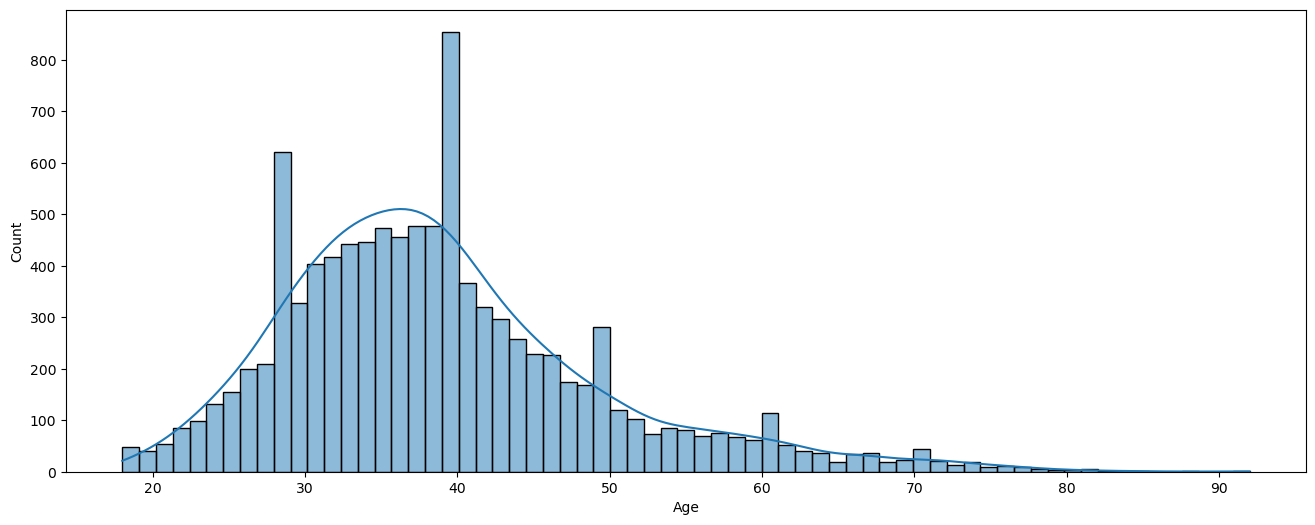

In [5]:
description_and_plot(data=data, column='Age')

Описательная статистика столбца "Tenure":
Среднее: 5.0±0.03
Медиана: 5.0, межквартильный размах: 5.0
Минимальное значение: 0.0. Максимальное значение: 10.0.


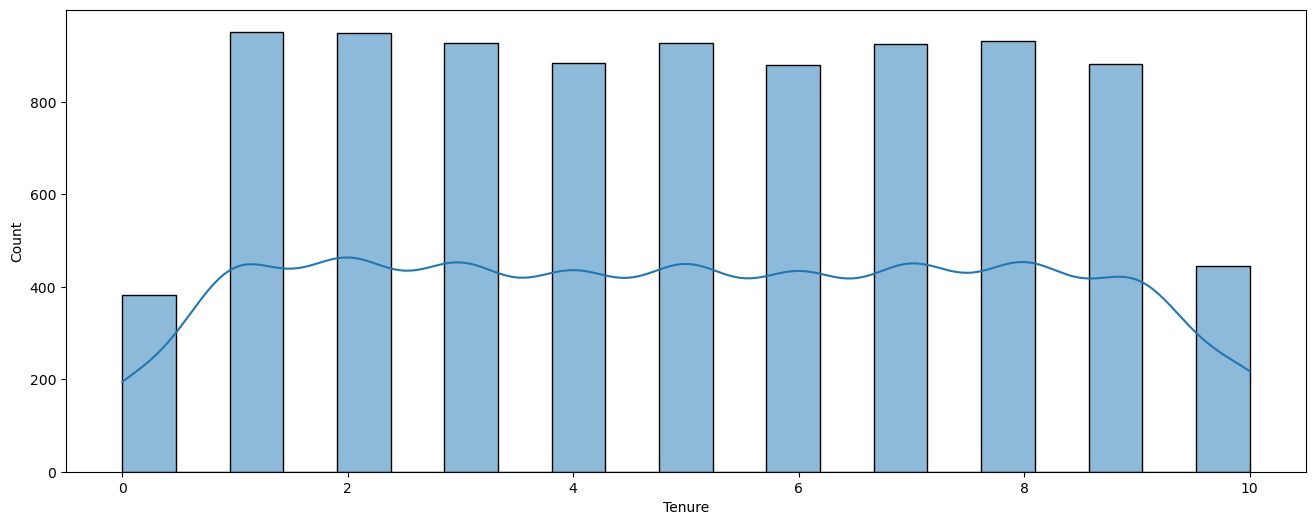

In [6]:
description_and_plot(data=data, column='Tenure')

Описательная статистика столбца "Balance":
Среднее: 76485.89±623.97
Медиана: 97198.54, межквартильный размах: 127644.24
Минимальное значение: 0.0. Максимальное значение: 250898.09.


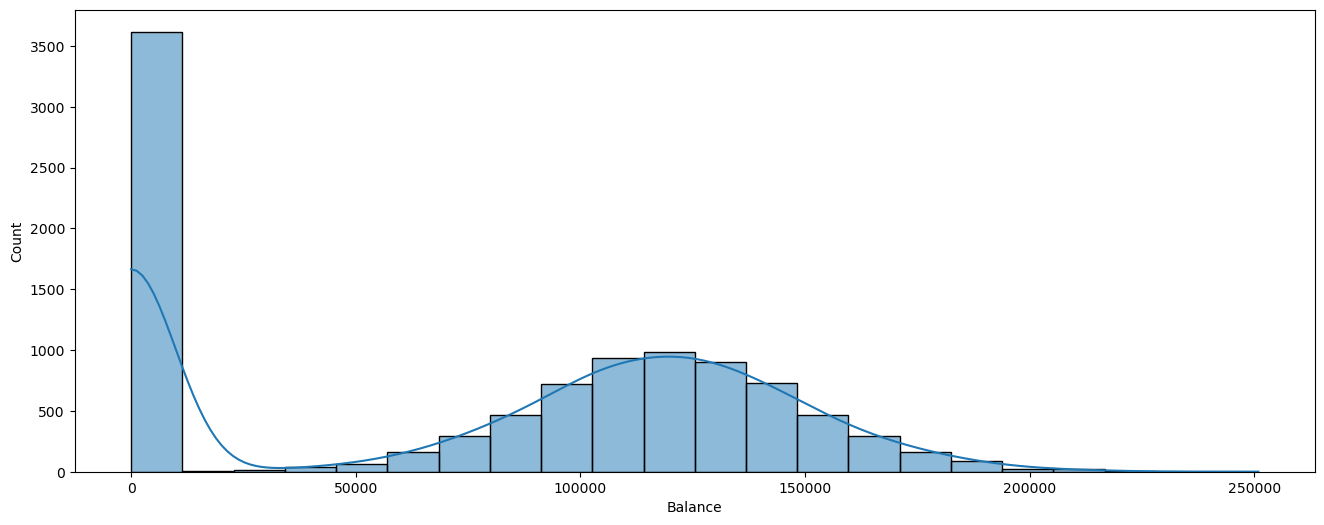

In [7]:
description_and_plot(data=data, column='Balance')

Описательная статистика столбца "EstimatedSalary":
Среднее: 100090.24±575.1
Медиана: 100193.92, межквартильный размах: 98386.14
Минимальное значение: 11.58. Максимальное значение: 199992.48.


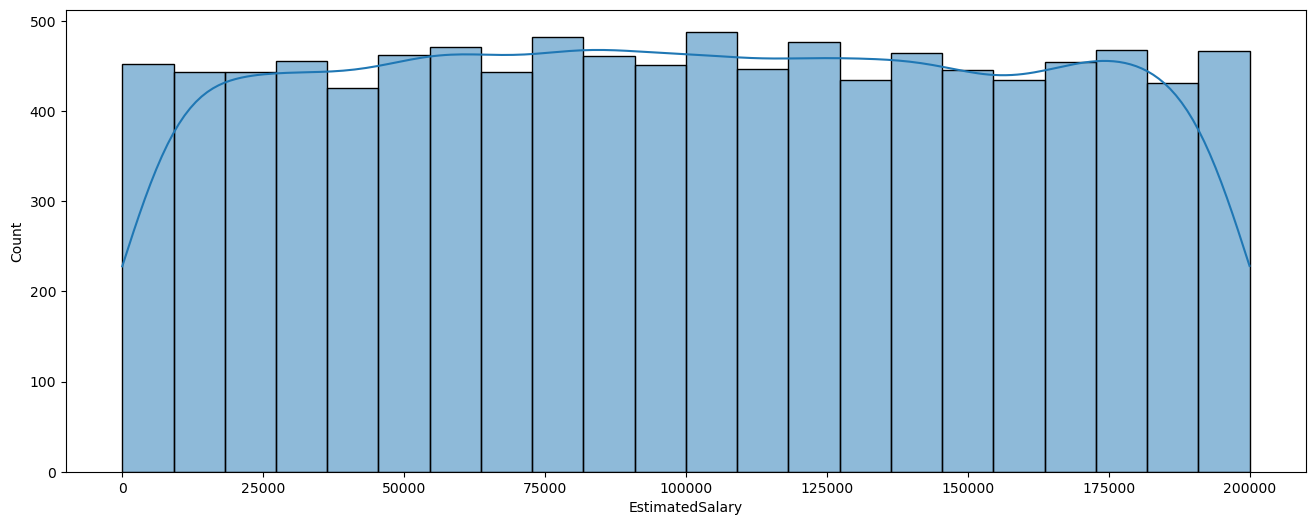

In [8]:
description_and_plot(data=data, column='EstimatedSalary')

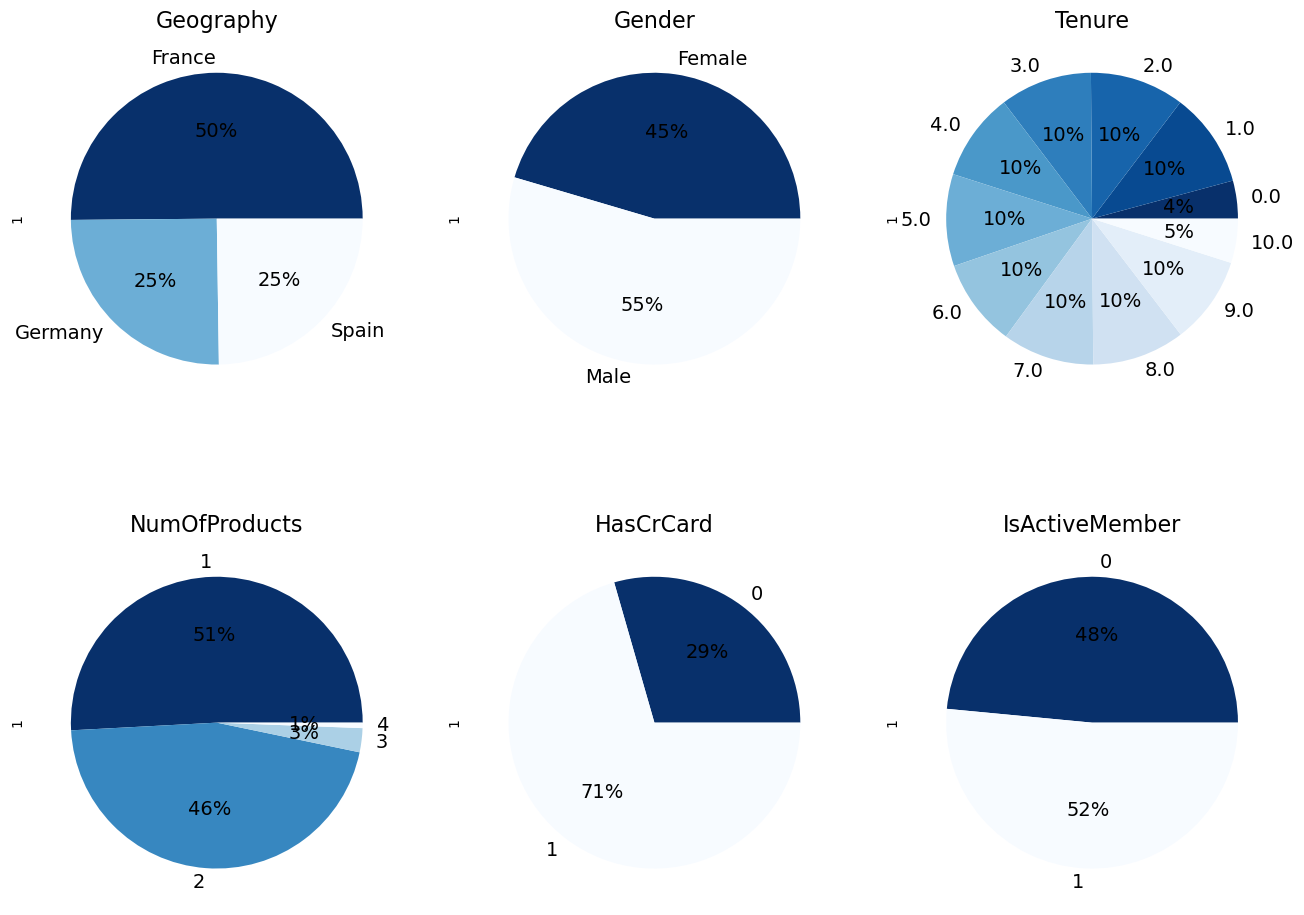

In [9]:
#Geography	Gender	Tenure	NumOfProducts	HasCrCard	IsActiveMember
data['1'] = 1


fig, axes = plt.subplots(2, 3, figsize=(16, 12))

# plot each pie chart in a separate subplot
data.groupby(['Geography'])['1'].sum().plot(
    kind='pie', autopct='%1.f%%', cmap="Blues_r", ax = axes[0,0], fontsize=14
)
data.groupby(['Gender'])['1'].sum().plot(
    kind='pie', autopct='%1.f%%', cmap="Blues_r", ax = axes[0,1], fontsize=14
)
data.groupby(['Tenure'])['1'].sum().plot(
    kind='pie', autopct='%1.f%%', cmap="Blues_r", ax = axes[0,2], fontsize=14
)
data.groupby(['NumOfProducts'])['1'].sum().plot(
    kind='pie', autopct='%1.f%%', cmap="Blues_r", ax = axes[1,0], fontsize=14
)
data.groupby(['HasCrCard'])['1'].sum().plot(
    kind='pie', autopct='%1.f%%', cmap="Blues_r", ax = axes[1,1], fontsize=14
)
data.groupby(['IsActiveMember'])['1'].sum().plot(
    kind='pie', autopct='%1.f%%', cmap="Blues_r", ax = axes[1,2], fontsize=14
)

axes[0,0].set_title('Geography', fontsize=16)
axes[0,1].set_title('Gender', fontsize=16)
axes[0,2].set_title('Tenure', fontsize=16)
axes[1,0].set_title('NumOfProducts', fontsize=16)
axes[1,1].set_title('HasCrCard', fontsize=16)
axes[1,2].set_title('IsActiveMember', fontsize=16)
plt.show()


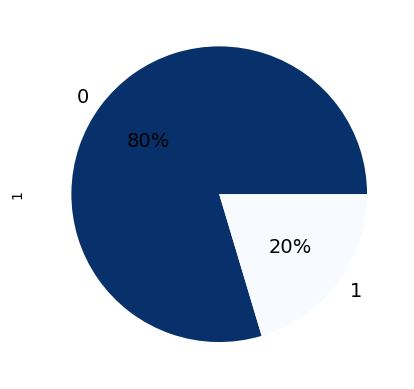

In [10]:
data.groupby(['Exited'])['1'].sum().plot(kind='pie', autopct='%1.f%%', cmap="Blues_r", fontsize=14);

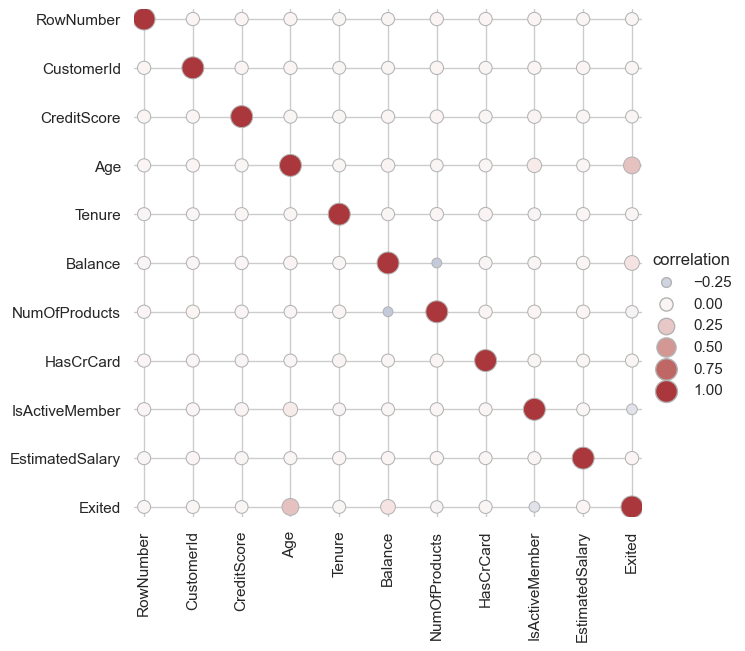

In [11]:
sns.set_theme(style="whitegrid")

corr_mat = data.corr().stack().reset_index(name="correlation")

g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=7, sizes=(50, 250), size_norm=(-.2, .8),
)

g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

In [12]:
index_na = []
for i in range(len(data['Age'])):
    if np.isnan(data.loc[i,'Tenure']) == True:
        index_na.append(i)

#print(index_na)
data_tenure = data.dropna() 

In [13]:
X = data_tenure.drop(['Tenure'], axis=1)
y = data_tenure['Tenure']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, 
    y, 
    test_size=0.40, 
    random_state=12345,
    stratify=y
)

In [14]:
data_test = pd.read_csv('C:/Users/Денис/Desktop/python/teacher/Churn_Modelling.csv')
data_test = data_test.loc[index_na,:]
X_test = data_test.drop(['Tenure'], axis=1)
y_test = data_test['Tenure']

In [27]:
print(y_test)

30       3
48       2
51       5
53       8
60       5
        ..
9944     7
9956    10
9964     5
9985     6
9999     4
Name: Tenure, Length: 909, dtype: int64


In [16]:
X_train = X_train.reset_index(drop=True)
X_train

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,1
0,1524,15751531,Shaw,598,Spain,Male,41,0.00,2,1,1,161954.43,0,1
1,1062,15692991,Wood,710,Spain,Female,38,0.00,2,1,1,136390.88,0,1
2,8365,15684395,Enderby,446,Spain,Female,45,125191.69,1,1,1,128260.86,1,1
3,3804,15651264,Yobanna,850,Germany,Male,51,124425.99,1,0,0,118545.49,1,1
4,1935,15584930,Grimmett,726,Germany,Male,30,111375.32,2,1,0,2704.09,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5449,7269,15587266,Douglas,606,Germany,Female,27,172310.33,1,0,1,111448.92,0,1
5450,9599,15666767,Lori,508,France,Male,35,86893.28,1,0,0,59374.82,0,1
5451,1220,15812272,Ugonna,693,Germany,Male,44,124601.58,2,1,1,46998.13,1,1
5452,1298,15793247,Hancock,498,France,Male,34,0.00,2,1,1,91711.66,0,1


In [17]:
#Geography	Gender	Tenure	NumOfProducts	HasCrCard	IsActiveMember Exited

#надо сбросить индексы чтобы нормально объединялдась таблица

X_train = X_train.reset_index(drop=True)

#кодируем значения в отдельных ячейках для страны, пола и количества продуктов
oe_Geography = OneHotEncoder()
oe_Geography_results = oe_Geography.fit_transform(X_train[['Geography']])
X_train = X_train.join(pd.DataFrame(oe_Geography_results.toarray(), columns=['France','Germany','Spain']))

oe_Gender = OneHotEncoder()
oe_Gender_results = oe_Gender.fit_transform(X_train[['Gender']])
X_train = X_train.join(pd.DataFrame(oe_Gender_results.toarray(), columns=['Female','Male']))

oe_NumOfProducts = OneHotEncoder()
oe_NumOfProducts_results = oe_NumOfProducts.fit_transform(X_train[['NumOfProducts']])
X_train = X_train.join(pd.DataFrame(oe_NumOfProducts_results.toarray(), columns=['num1','num2','num3','num4']))

#дропаем все не нужные для модели категории
X_train = X_train.drop(['Geography', 'Gender', 'NumOfProducts','RowNumber', 'CustomerId', 'Surname'], axis= 1)

#посмотрим что вышло
X_train.head()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,1,France,Germany,Spain,Female,Male,num1,num2,num3,num4
0,598,41,0.00,1,1,161954.43,0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,710,38,0.00,1,1,136390.88,0,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,446,45,125191.69,1,1,128260.86,1,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,850,51,124425.99,0,0,118545.49,1,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,726,30,111375.32,1,0,2704.09,0,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [18]:
y_train

1523     8.0
1061     4.0
8364    10.0
3803     4.0
1934     5.0
        ... 
7268     6.0
9598     1.0
1219     5.0
1297     5.0
6828     9.0
Name: Tenure, Length: 5454, dtype: float64

In [19]:
X_valid = X_valid.reset_index(drop=True)

#кодируем значения в отдельных ячейках для страны, пола и количества продуктов
oe_Geography_results = oe_Geography.transform(X_valid[['Geography']])
X_valid = X_valid.join(pd.DataFrame(oe_Geography_results.toarray(), columns=['France','Germany','Spain']))

oe_Gender_results = oe_Gender.transform(X_valid[['Gender']])
X_valid = X_valid.join(pd.DataFrame(oe_Gender_results.toarray(), columns=['Female','Male']))

oe_NumOfProducts_results = oe_NumOfProducts.transform(X_valid[['NumOfProducts']])
X_valid = X_valid.join(pd.DataFrame(oe_NumOfProducts_results.toarray(), columns=['num1','num2','num3','num4']))

#дропаем все не нужные для модели категории
X_valid = X_valid.drop(['Geography', 'Gender', 'NumOfProducts','RowNumber', 'CustomerId', 'Surname'], axis= 1)


X_valid.head()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,1,France,Germany,Spain,Female,Male,num1,num2,num3,num4
0,386,53,131955.07,1,1,62514.65,1,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,575,29,121823.40,1,1,50368.87,0,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,625,31,77743.01,1,0,75335.68,0,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,554,31,135470.90,1,0,107074.81,0,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,676,35,0.00,0,0,139911.58,0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [20]:
X_valid.head()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,1,France,Germany,Spain,Female,Male,num1,num2,num3,num4
0,386,53,131955.07,1,1,62514.65,1,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,575,29,121823.40,1,1,50368.87,0,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,625,31,77743.01,1,0,75335.68,0,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,554,31,135470.90,1,0,107074.81,0,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,676,35,0.00,0,0,139911.58,0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [21]:
print(oe_Geography_results)

  (0, 2)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 1)	1.0
  (4, 2)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 1)	1.0
  (9, 0)	1.0
  (10, 0)	1.0
  (11, 2)	1.0
  (12, 2)	1.0
  (13, 1)	1.0
  (14, 0)	1.0
  (15, 2)	1.0
  (16, 1)	1.0
  (17, 0)	1.0
  (18, 0)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 1)	1.0
  (22, 0)	1.0
  (23, 1)	1.0
  (24, 0)	1.0
  :	:
  (3612, 1)	1.0
  (3613, 1)	1.0
  (3614, 1)	1.0
  (3615, 0)	1.0
  (3616, 0)	1.0
  (3617, 0)	1.0
  (3618, 2)	1.0
  (3619, 2)	1.0
  (3620, 1)	1.0
  (3621, 1)	1.0
  (3622, 1)	1.0
  (3623, 0)	1.0
  (3624, 2)	1.0
  (3625, 0)	1.0
  (3626, 1)	1.0
  (3627, 1)	1.0
  (3628, 1)	1.0
  (3629, 0)	1.0
  (3630, 0)	1.0
  (3631, 0)	1.0
  (3632, 0)	1.0
  (3633, 1)	1.0
  (3634, 0)	1.0
  (3635, 0)	1.0
  (3636, 1)	1.0


In [22]:
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

In [23]:
scores = np.zeros((22, 22))
best_model_tree = None
best_result = 0
for i in range(1,11):
    for j in range(2,22): 
        model = DecisionTreeClassifier(random_state=12345, max_depth=i, max_leaf_nodes=j)
        model.fit(X_train, y_train)
        result = model.score(X_valid, y_valid)
        scores[i,j] = result
        if result > best_result:
            best_result = result 
            best_max_depth = i
            best_max_leaf_nodes = j
            best_model_tree = model
print(f'best max_depth = {best_max_depth}, best_max_leaf_nodes {best_max_leaf_nodes}: {best_result}')

best max_depth = 1, best_max_leaf_nodes 2: 0.10448171569975254


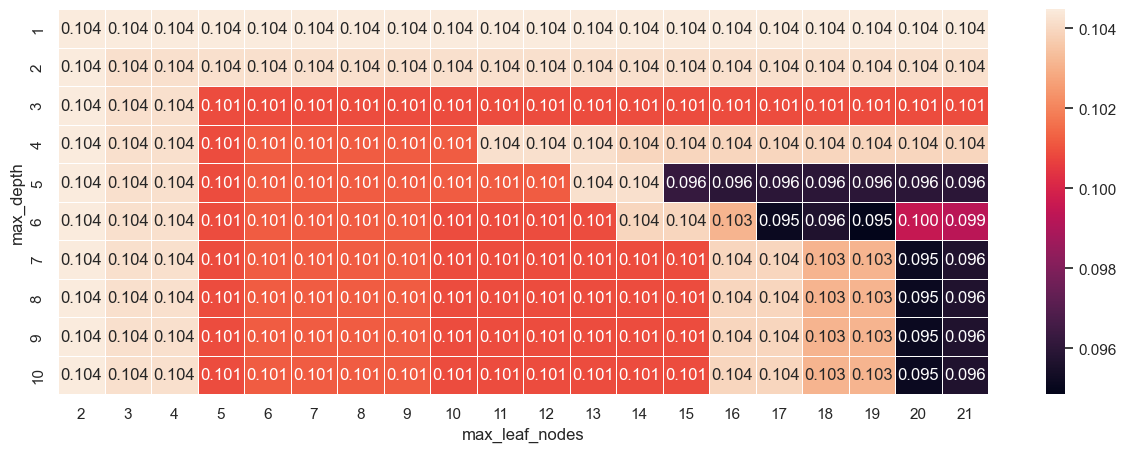

In [24]:
plt.figure(figsize=(15, 5))
ax = sns.heatmap(scores[1:11,2:22], annot=True, fmt=".3f", linewidth=.5)
ax.set(xlabel="max_leaf_nodes", ylabel="max_depth", xticklabels=range(2,22), yticklabels=range(1,11));

In [25]:
model_lgst = LogisticRegression(
    # параметр для остановки поиска решения.
    tol=1e-4,
    # Так как распознается 2 класса.
    multi_class='multinomial')
model_lgst.fit(X_train, y_train) # обучите модель на тренировочной выборке
result = model_lgst.score(X_valid, y_valid) # посчитайте качество модели на валидационной выборке
print(f'result = {result}')

result = 0.10200714874896893


## Исследование задачи

## Борьба с дисбалансом

## Тестирование модели

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*